# Imports

In [1]:
import numpy as np
import tensorflow as tf
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preprocessing

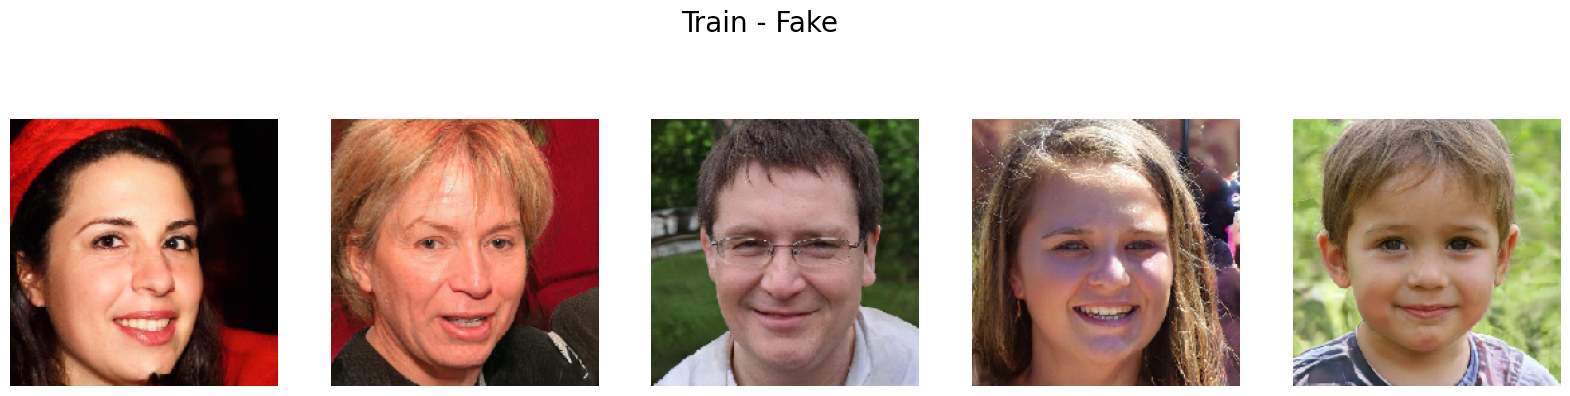

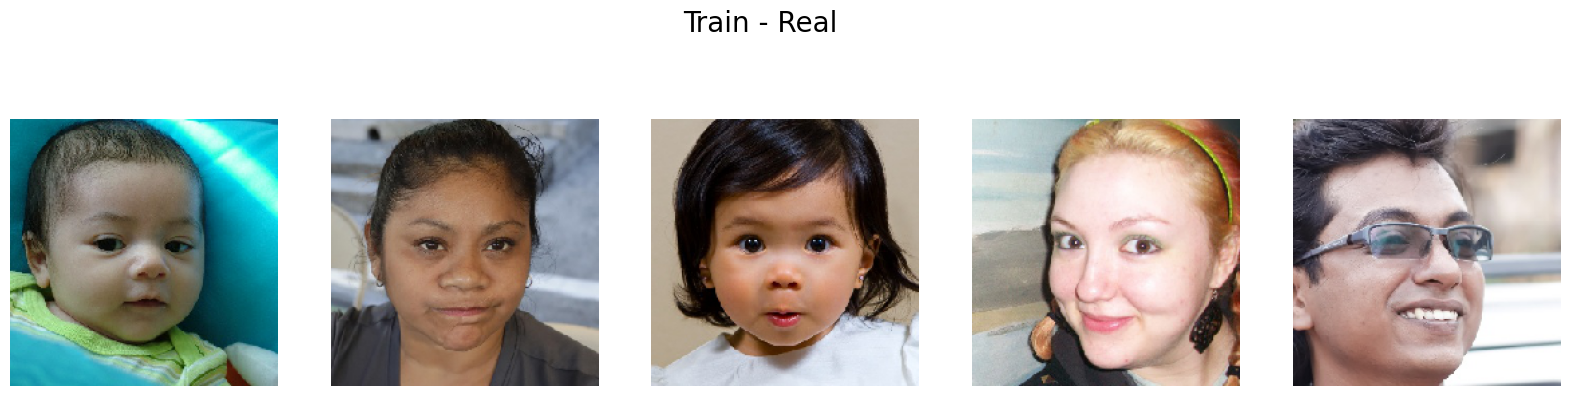

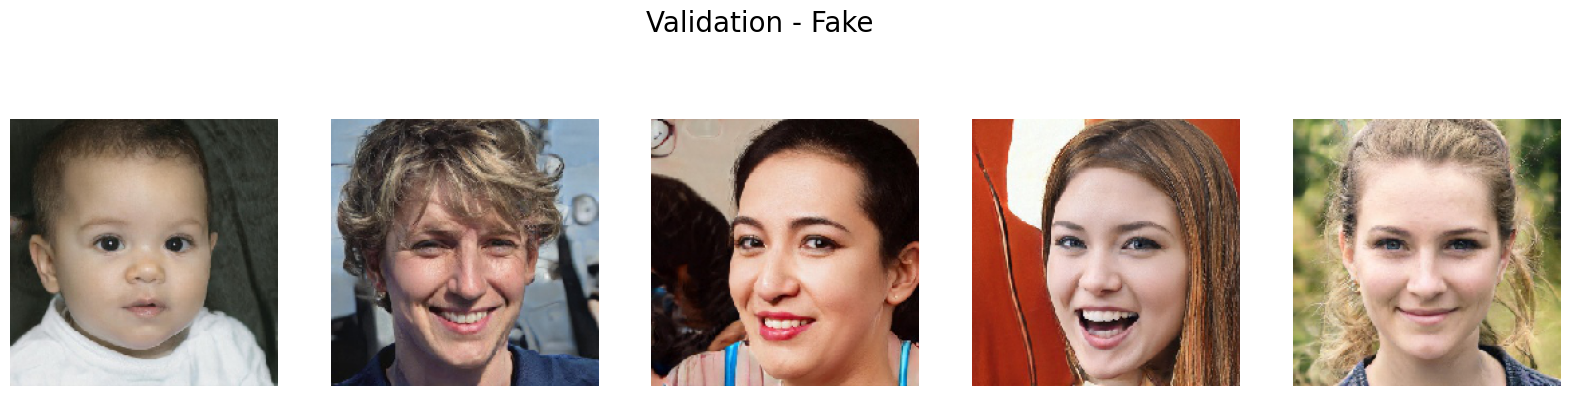

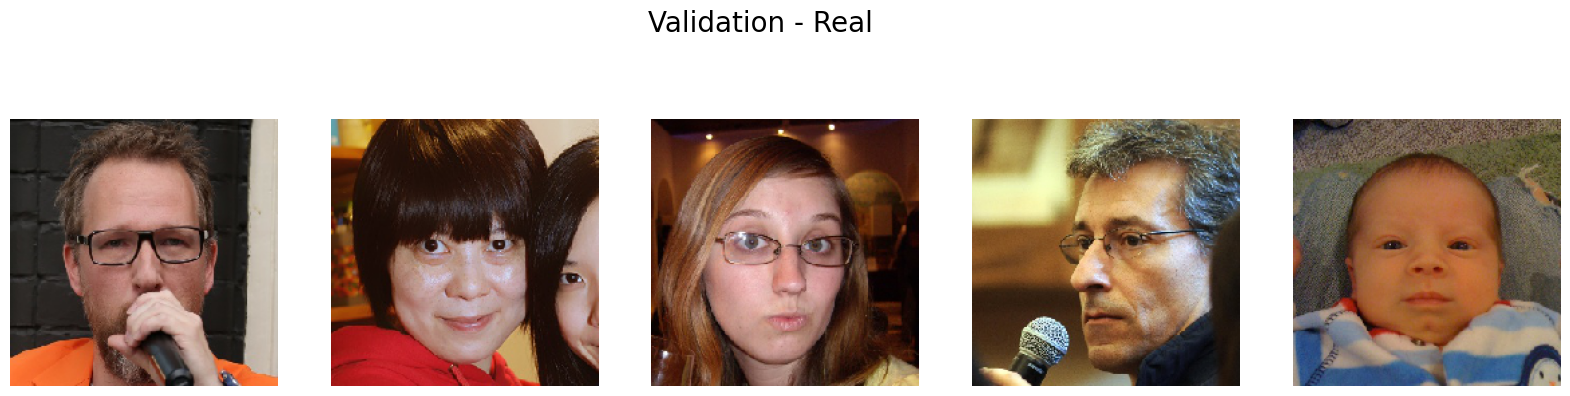

In [2]:
def show_images(directory, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    fig.suptitle(title, fontsize=20)
    
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    for i, ax in enumerate(axes):
        if i < len(image_files):
            img_path = os.path.join(directory, image_files[i])
            img = load_img(img_path, target_size=(200, 200))
            ax.imshow(img)
            ax.axis('off')
    
    plt.show()

show_images('Dataset/Train/Fake', 'Train - Fake', num_images=5)
show_images('Dataset/Train/Real', 'Train - Real', num_images=5)
show_images('Dataset/Validation/Fake', 'Validation - Fake', num_images=5)
show_images('Dataset/Validation/Real', 'Validation - Real', num_images=5)

In [3]:
# Mendefinisikan augmentasi dan prapemrosesan untuk data latih dan validasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True
)

# Memuat dan melakukan praproses data pelatihan dan validasi
train_generator = datagen.flow_from_directory(
    'Dataset/Train',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)
validation_generator = datagen.flow_from_directory(
    'Dataset/Validation',
    target_size=(200, 200), 
    batch_size=32,
    class_mode='binary'
)

# Print class indices
print("Train Label:\n", train_generator.class_indices)
print("Validation Label:\n", validation_generator.class_indices)

Found 242043 images belonging to 2 classes.
Found 59428 images belonging to 2 classes.
Train Label:
 {'Fake': 0, 'Real': 1}
Validation Label:
 {'Fake': 0, 'Real': 1}


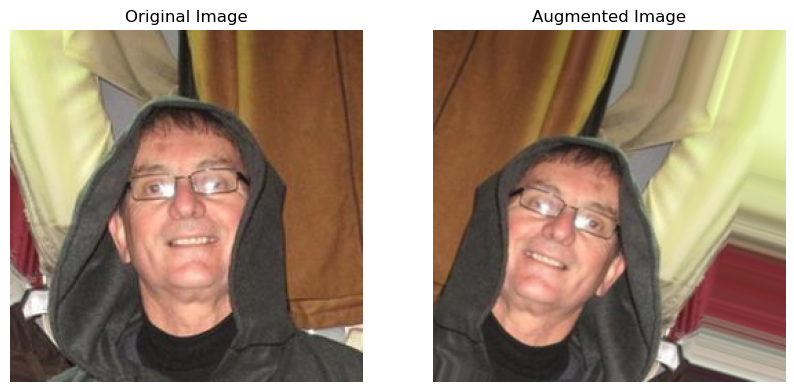

In [4]:
img_path = 'Dataset/Train/Real/real_0.jpg'
img = load_img(img_path) 
x = img_to_array(img) 
x = np.expand_dims(x, axis=0)

gen = datagen.flow(x, batch_size=1)

augmented_image = next(gen)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(augmented_image)
ax[1].set_title('Augmented Image')
ax[1].axis('off')

plt.show()

# Model Building

In [5]:
# Memuat pre-trained EfficientNetV2B0
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3),
    pooling='max',
    classes=2,
    include_preprocessing=True
)

base_model.trainable = True

# Classification head kustom
x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi modelnya
model.compile(
    optimizer = Adam(learning_rate=0.00001),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 200, 200, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 200, 200, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 100, 100, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 100, 100, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 100, 100, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 100, 100, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 100, 100, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 100, 100, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 50, 50, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 50, 50, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 50, 50, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 50, 50, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 50, 50, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 50, 50, 128)       │          36,86

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 5,859,985 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

# Model Training

In [6]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10


C:\Users\Sakadyk\anaconda3\envs\pi24\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7564/7564 ━━━━━━━━━━━━━━━━━━━━ 5022s 660ms/step - accuracy: 0.6394 - loss: 0.8225 - val_accuracy: 0.7703 - val_loss: 0.4816
Epoch 2/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 4348s 575ms/step - accuracy: 0.7944 - loss: 0.4275 - val_accuracy: 0.8489 - val_loss: 0.3411
Epoch 3/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 4380s 579ms/step - accuracy: 0.8627 - loss: 0.3061 - val_accuracy: 0.8899 - val_loss: 0.2619
Epoch 4/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 4801s 635ms/step - accuracy: 0.8970 - loss: 0.2396 - val_accuracy: 0.9081 - val_loss: 0.2204
Epoch 5/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 5043s 667ms/step - accuracy: 0.9194 - loss: 0.1937 - val_accuracy: 0.9270 - val_loss: 0.1821
Epoch 6/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 5124s 677ms/step - accuracy: 0.9329 - loss: 0.1656 - val_accuracy: 0.9210 - val_loss: 0.1968
Epoch 7/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 4908s 649ms/step - accuracy: 0.9418 - loss: 0.1471 - val_accuracy: 0.9434 - val_loss: 0.1440
Epoch 8/10
7564/7564 ━━━━━━━━━━━━━━━━━━━━ 4970s 657ms/step - accur

In [11]:
import json
import pickle

# Simpan data history dari file JSON
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Simpan data history ke file Pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Model Saving

In [9]:
model.save('model_pi_roy.h5')
# Format alternatif
model.save('model_pi_roy.keras')

In [13]:
export_path = 'model_pi_roy'
model.export(export_path)

INFO:tensorflow:Assets written to: model_pi_roy\assets


INFO:tensorflow:Assets written to: model_pi_roy\assets


Saved artifact at 'model_pi_roy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2332387861584: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2332632730896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2332632732432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632733008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632731472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632731856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632732048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632733584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632732624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632730512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2332632732816: Tenso